In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax.config import config
config.update("jax_debug_nans", True)
config.update('jax_enable_x64', True)


In [3]:
import itertools
import math
from functools import partial

import numpy as onp

import jax
print("jax version: ", jax.__version__)
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt

import IMNN
print("IMNN version: ", IMNN.__version__)

from IMNN.experimental.jax.imnn import (
    AggregatedGradientIMNN,
    AggregatedNumericalGradientIMNN,
    AggregatedSimulatorIMNN,
    GradientIMNN,
    NumericalGradientIMNN,
    SimulatorIMNN,
)
from IMNN.experimental.jax.lfi import (
    ApproximateBayesianComputation,
    GaussianApproximation,
)
from IMNN.experimental.jax.utils import value_and_jacrev, value_and_jacfwd

rng = jax.random.PRNGKey(0)


jax version:  0.2.8
IMNN version:  0.2dev


# simulator

In [4]:
n_summaries = 2
n_s = 10000
n_d = 5000
λ = 100.0
ϵ = 0.1

In [5]:
θ_fid = np.array([1.0, 0.5], dtype=np.float32)
δθ = np.array([0.1, 0.1], dtype=np.float32)
n_params = 2
N = 128
dim = 2
L = 128

field_shape = (N,N)
dx = L / N
fourier_b = 2*np.pi
input_shape = (1,1, N,N)
simulator_args = {"N": N, "L": L, "dim": dim, "shape": field_shape, 'vol_norm': False, "N_scale": True, "squeeze": False}

In [6]:
# define noise
rng,fg_key = jax.random.split(rng)
foregrounds = jax.random.normal(fg_key, (1000, 1,) + simulator_args['shape'])*0


def simulator(rng, θ, simulator_args=simulator_args):
    def P(k, A=1, B=1):
        def fnk(k):
            return jax.lax.cond(np.equal(k, 0.), lambda _: 0., lambda k: (A * k ** -B), operand=k)
        
        if len(k.shape) == 1:
            return jax.vmap(fnk)(k)
        else:
            return jax.vmap(partial(P, A=A, B=B))(k)
    
    def fn(key, A, B):
        shape = simulator_args["shape"]
        
        k = np.sqrt(np.sum(np.array(np.meshgrid(*(
            (np.hstack((np.arange(0, _shape//2 + 1), 
                np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape)**2
                for _shape in shape))), axis=0))
        
        new_shape = ()
        for _shape in shape:
            if _shape % 2 == 0:
                new_shape += (_shape+1,)
            else:
                new_shape += (_shape,)
        
        
        key1,key2 = jax.random.split(key)
        
        foreground = foregrounds[jax.random.randint(key2, 
                                        minval=0, maxval=1000, shape=())]
        
        # L is in length units, like Gpc
        L = simulator_args['L']
        dim = simulator_args['dim']
        
        if np.isscalar(L):
            L = [L]*int(dim)
        
        else:
            L = np.array(L)
            
        
        V = np.prod(np.array(L))
        
        scale = V**(1./dim)
        
        Lk = ()
        
        _N = 1
        for i,_shape in enumerate(shape):
            _N *= _shape
            Lk += (_shape / L[i],) # 1 / dx
            

        fft_norm = np.prod(np.array(Lk))
        
        _dims = len(shape)
        tpl = ()
        for _d in range(_dims):
            tpl += (_d,)

# POWERBOX IMPLEMENTATION

        mag = jax.random.normal(key1, shape=tuple(N for N in new_shape))
        # random phases
        pha = 2 * np.pi * jax.random.uniform(key1, shape=tuple(N for N in new_shape))
        # now make hermitian field (reality condition)

        revidx = (slice(None, None, -1),) * len(mag.shape)

        
        mag = (mag + mag[revidx]) / np.sqrt(2)

        
        pha = (pha - pha[revidx]) / 2 + np.pi
        dk = mag * (np.cos(pha) + 1j * np.sin(pha)) # output is complex
        
        cutidx = (slice(None, -1),) * len(new_shape)
        
        dk = dk[cutidx]
        
        powers = np.concatenate((np.zeros(1), 
                    np.sqrt(P(k.flatten()[1:], A=A, B=B)))).reshape(k.shape)
        
        # normalize power by volume
        if simulator_args['vol_norm']:
            powers = powers/V
        
        fourier_field = powers * dk
        
        fourier_field = jax.ops.index_update(
            fourier_field,
            np.zeros(len(shape), dtype=int),
            np.zeros((1,)))
        
        field = np.expand_dims(np.fft.ifftn(fourier_field) * fft_norm * V, (0,))
        
        if simulator_args["N_scale"]:
            field *= scale
        
        if not simulator_args["squeeze"]:
            field = np.expand_dims(field, (0,))

        return np.array(np.real((field)), dtype='float32')
        
    shape = simulator_args["shape"]
    A, B = θ
    #k = np.sqrt(np.sum(np.array(np.meshgrid(*(((2. * np.pi) / N) * np.arange(N // 2) for N in shape)))**2., 0))
    #return fn(key, A, B)
    
    
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, B)

# sim and gradient

In [7]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

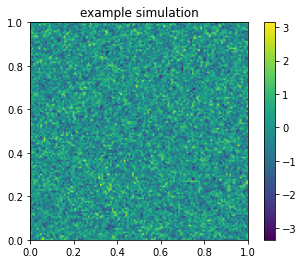

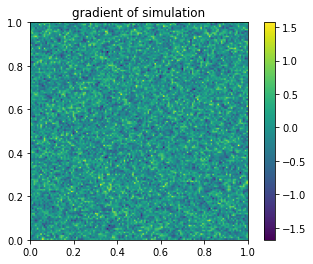

In [8]:
# plot example simulation and derivative
deriv_args = {"N": N, "L": 128, "dim": dim, "shape": field_shape, "vol_norm": True, "N_scale": True, "squeeze": False}
simulation, simulation_gradient = value_and_jacfwd(simulator, argnums=1)(rng, θ_fid, simulator_args=deriv_args)

plt.imshow(np.squeeze(simulation[0]), extent=(0,1,0,1))
plt.colorbar()
plt.title('example simulation')
plt.show()

plt.imshow(np.squeeze(simulation_gradient[0].T[0].T), extent=(0,1,0,1))
plt.title('gradient of simulation')
plt.colorbar()
plt.show()

# analytic Fisher

In [9]:
import powerbox as pbox

A,B = θ_fid
#sim = np.squeeze(simulator(rng, θ_fid, simulator_args={"N": N, "squeeze":True, "L": L, "dim": 2}))

shape = simulator_args["shape"]
kmax = 0.5 
kmin = 0.5 / N

#kbin = np.linspace(kmin, kmax, num=N**2)
kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(((2. * np.pi) / N) * np.arange(N // 2) for N in shape)))**2., 0))


def fisher_approx(θ, kmin, kmax):
    A,B = θ
    Faa = (1/A)**2 * (np.log(kmax) - np.log(kmin))
    Fab = (1/(2*A)) * ((np.log(kmax))**2 - (np.log(kmin))**2)
    Fbb = ((np.log(kmax))**3 - (np.log(kmin))**3) / 3
    
    return np.array([[Faa, Fab], [Fab, Fbb]]) * 2*np.pi

def fisher(θ, kvec, N=32, dim=2, L=None):
    A,B = θ
    if L is not None:
        V = L**dim
    else: 
        V = N**2     # physical box volume
        
    
    #dk = kvec[1] - kvec[0]
    Nk = N**dim      # number of k modes
    pk = lambda k : A*(k**-B)              # P(k) = Ak^(-B)
    p_a = lambda k : k**-B                # deriv w.r.t. A
    p_b = lambda k : -A*(k**-B)*np.log(k) # deriv w.r.t. B
    
    
    powers = np.concatenate((np.ones(1), 
        (pk(kvec.flatten()[1:])))) 
    
    powera = np.concatenate((np.zeros(1), 
        (p_a(kvec.flatten()[1:]))))
    
    powerb = np.concatenate((np.zeros(1), 
        (p_b(kvec.flatten()[1:])))) 
    
    
    Cinv = np.diag(2. / (powers))          # diagonal inv. covariance
    Ca =  np.diag(powera / 2.)           # C_{,A}
    Cb =  np.diag(powerb / 2.)           # C_{,B}

    Faa = 0.5 * np.trace((Ca @ Cinv @ Ca @ Cinv))
    Fab = 0.5 * np.trace((Ca @ Cinv @ Cb @ Cinv))
    Fba = 0.5 * np.trace((Cb @ Cinv @ Ca @ Cinv))
    Fbb = 0.5 * np.trace((Cb @ Cinv @ Cb @ Cinv))
    
    return np.array([[Faa, Fab], [Fba, Fbb]]) #* 0.5 #* 1 / np.sqrt(2)

In [10]:
N = simulator_args["N"]
shape = simulator_args["shape"]
# kbin = np.sqrt(np.sum(
#     np.array(np.meshgrid(*(np.arange(N // 2) * ((2. * np.pi) / (N))
#                            for N in shape)))**2., 0)).flatten()

# kbin = np.sqrt(np.sum(
#     np.array(np.meshgrid(*(np.arange(N//2) * ((2. * np.pi) / (N))
#                            for N in shape)))**2., 0)).flatten()

kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) *2* np.pi / _shape
        for _shape in shape)))**2, axis=0))


print('k array extents: ', '[%f, %f]'%(np.min(kbin), np.max(kbin)))
print('k vector length: ', len(kbin))

f_expected = fisher(θ_fid, kbin[:N//2, :N//2])
print("analytic F(θ_fid): ", f_expected)

detf_expected = np.linalg.det(f_expected)
print("analytic det(F(θ_fid)): ", detf_expected)

k array extents:  [0.000000, 4.442883]
k vector length:  128
analytic F(θ_fid):  [[ 2047.5        -1556.1814602 ]
 [-1556.1814602   1743.09245971]]
analytic det(F(θ_fid)):  1147281.074201786


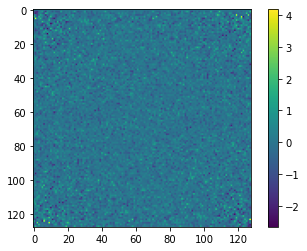

In [11]:
# MAKE SIMULATION
N = simulator_args["N"]
shape = (N,N)

θ_sim = np.array([0.7, 0.8])
simulator_args = {"N": N, "L": 1, "dim": dim, "shape": shape, "vol_norm": True, "N_scale": False, "squeeze": True}
simulator_args["shape"] = (N,N)
simkey,rng = jax.random.split(rng)
#sim = np.squeeze(target_data)#
sim = np.squeeze(simulator(simkey, θ_sim, simulator_args=simulator_args))
sim_fft = (np.fft.fft2(sim)) / (N**2)


plt.imshow(np.real(sim_fft))
plt.colorbar()

domain_size 0.0018095603412635493
(20, 20)


/mnt/home/tmakinen/anaconda3/envs/pyjax/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'B')

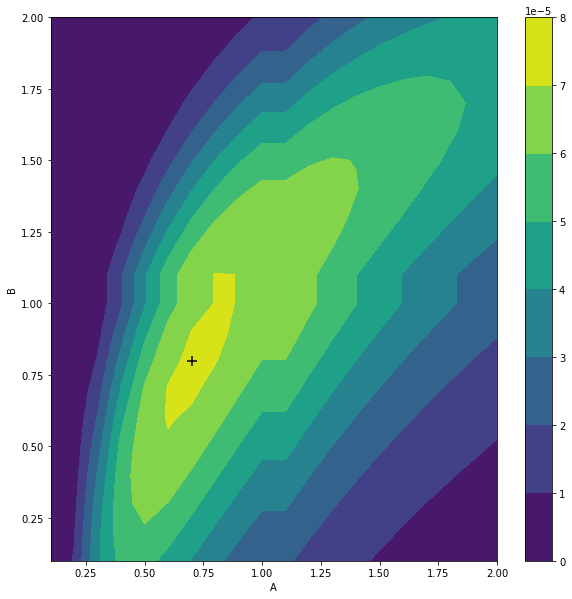

In [12]:
shape = simulator_args["shape"]

kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape
        for _shape in shape)))**2, axis=0))



def Pk(k, A=1, B=0.5, N=32):
    eps = 1./N
    return (A * (k+eps) ** -B) #/ N**2

def Cov(k, A, B):
    pk = Pk(k, A, B) 

    return np.diag(pk)
def get_likelihood(k, A, B, Δ):
    Δ = Δ.flatten()
    k = k
    
    dlength = len(k.flatten())
    
    def fn(_A, _B):
        
        nrm = np.pad(np.ones(dlength-2)*2, (1,1), constant_values=1.)
        nrm = jax.ops.index_update(
          nrm, np.array([[0],[(dlength-2)]]), np.array([[1],[1]]))
        #nrm = 1
        
        powers = np.concatenate((np.ones(1), 
                (Pk(k.flatten()[1:], A=_A, B=_B))))
        
          
        C = powers * nrm
        invC = np.concatenate((np.zeros(1), 
           (1./Pk(k.flatten()[1:], A=_A, B=_B))))#*np.eye(len(k.flatten()))
        
        logdetC = np.sum(np.log(C))
        pi2 = np.pi * 2.
        m_half_size = -0.5 * len(Δ) #- 0.5* Δ.shape[0] #// 2
        exponent = - 0.5 * np.sum(np.conj(Δ) * invC * Δ) #np.einsum("i,ij,j->", np.conj(Δ), (invC), (Δ))
        norm = -0.5 * logdetC + m_half_size*np.log(pi2) 
        return (exponent + norm)
    return jax.vmap(fn)(A, B)

size = 20                # for likelihood gridding
Δ = sim_fft[:N//2, :N//2] #/ N**2
k = kbin[:N//2, :N//2]    

A_start = 0.1
A_end = 2.0
B_start = 0.1
B_end = 2.0

# go by quadrant
qsize = 10

# 3 4
# 1 2

# bottom quadrant 1
A_range = np.linspace(0.1, 1, qsize)
B_range = np.linspace(0.1, 1, qsize)
domain_size = 1. / np.log(1e240) #((A_range[1]-A_range[0]) * (A_range[1]-B_range[0]))
print('domain_size', domain_size)

A, B = np.meshgrid(A_range, B_range)
likelihood_1 = np.exp(get_likelihood(k, 
                A.ravel(), B.ravel(), Δ).reshape(qsize,qsize) * domain_size)

# quadrant 2
A_range = np.linspace(1, 2, qsize)
#domain_size = ((A_range[1]-A_range[0]) * (A_range[1]-B_range[0]))
A, B = np.meshgrid(A_range, B_range)
likelihood_2 = np.exp(get_likelihood(k, 
                A.ravel(), B.ravel(), Δ).reshape(qsize,qsize) * domain_size)

# quadrant 3
A_range = np.linspace(0.1, 1, qsize)
B_range = np.linspace(1, 2, qsize)
#domain_size = ((A_range[1]-A_range[0]) * (A_range[1]-B_range[0]))
A, B = np.meshgrid(A_range, B_range)
likelihood_3 = np.exp(get_likelihood(k, 
                A.ravel(), B.ravel(), Δ).reshape(qsize,qsize) * domain_size)

# quadrant 4
A_range = np.linspace(1, 2, qsize)
#domain_size = ((A_range[1]-A_range[0]) * (A_range[1]-B_range[0]))
A, B = np.meshgrid(A_range, B_range)
likelihood_4 = np.exp(get_likelihood(k, 
                A.ravel(), B.ravel(), Δ).reshape(qsize,qsize) * domain_size)
                      
                      
# concatenate results
likelihood = np.concatenate(
    [np.concatenate([likelihood_1, likelihood_2], axis=1),
     np.concatenate([likelihood_3, likelihood_4], axis=1)],
    axis=0)
A_range = np.linspace(0.1, 2, 20)
B_range = np.linspace(0.1, 2, 20)

A, B = np.meshgrid(A_range, B_range)

print(likelihood.shape)


plt.figure(figsize=(10,10))
plt.contourf(A_range, B_range, likelihood)
#plt.contourf(A_range2, B_range2, L2.reshape((size, size)))

plt.colorbar()

plt.scatter(θ_sim[0], θ_sim[1], zorder=10, marker='+', s=100, color='k')

plt.xlabel('A')
plt.ylabel('B')

In [45]:
# computing likelihood function

shape = simulator_args["shape"]

kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape
        for _shape in shape)))**2, axis=0))


class analytic_likelihood():
    
    def __init__(self, field_shape,
                 k,
                 Δ,
                 prior,
                 gridsize=20, 
                 tiling=2, 
                ):
        """code for computing a gaussian field's likelihood for power spectrum parameters
            tiling : list or int. tiling=2 means likelihood will be computed as 2x2 grid
        """
        self.field_shape = field_shape
        self.gridsize = gridsize
        if np.isscalar(tiling):
            self.tiling = [tiling]*2
        else:
            self.tiling = tiling    
        #self.tilesize = gridsize // tiling
        self.N = np.sqrt(np.prod(np.array(field_shape)))  # should just be N for NxN grid
        self.prior = prior
        
        self.k = k
        self.Δ = Δ

    def Pk(self, k, A=1, B=0.5, N=32):
        eps = 1./self.N  # for num. stability
        return (A * (k+eps) ** -B) #/ N**2

    def Cov(self, k, A, B):
        pk = self.Pk(k, A, B) 

        return np.diag(pk)
    def log_likelihood(self, k, A, B, Δ):
        Δ = Δ.flatten()
        k = k

        dlength = len(k.flatten())

        def fn(_A, _B):

            nrm = np.pad(np.ones(dlength-2)*2, (1,1), constant_values=1.)
            nrm = jax.ops.index_update(
              nrm, np.array([[0],[(dlength-2)]]), np.array([[1],[1]]))
            #nrm = 1

            powers = np.concatenate((np.ones(1), 
                    (self.Pk(k.flatten()[1:], A=_A, B=_B))))

            
            C = powers * nrm
            invC = np.concatenate((np.zeros(1), 
               (1./self.Pk(k.flatten()[1:], A=_A, B=_B))))

            logdetC = np.sum(np.log(C))
            pi2 = np.pi * 2.
            m_half_size = -0.5 * len(Δ) #- 0.5* Δ.shape[0] #// 2
            exponent = - 0.5 * np.sum(np.conj(Δ) * invC * Δ) #np.einsum("i,ij,j->", np.conj(Δ), (invC), (Δ))
            norm = -0.5 * logdetC + m_half_size*np.log(pi2) 
            return (exponent + norm) + np.log(3e200)
        return jax.vmap(fn)(A, B)
    
    def get_likelihood(self, norm=1./np.log(1e240), return_grid=False):
        A_start = self.prior[0][0]
        A_end = self.prior[1][0]
        B_start = self.prior[0][1]
        B_end = self.prior[1][1]
        
        region_size = [self.gridsize // self.tiling[i] for i in range(len(self.tiling))]
        
        print("computing likelihood on a %dx%d grid \n \
        in tiles of size %dx%d"%(self.gridsize, self.gridsize, region_size[0], region_size[1]))
        
        
        def get_like_region(A0, A1, B0, B1, qsize, norm):
            A_range = np.linspace(A0, A1, qsize)
            B_range = np.linspace(B0, B1, qsize)
            A, B = np.meshgrid(A_range, B_range)
            return np.exp(self.log_likelihood(k, 
                A.ravel(), B.ravel(), Δ).reshape(qsize,qsize) * norm)
        

        
        A_incr = (A_end - A_start) / self.tiling[0]
        B_incr = (B_end - B_start) / self.tiling[1]
        
        # marks the ends of linspace
        A_starts = [A_start + (i)*A_incr for i in range(self.tiling[0])]
        A_ends = [A_start + (i+1)*A_incr for i in range(self.tiling[0])]
        B_starts = [B_start + (i)*B_incr for i in range(self.tiling[1])]
        B_ends = [B_start + (i+1)*B_incr for i in range(self.tiling[1])]
        
        _like_cols = []
        for _col in range(self.tiling[0]):
            # slide horizontally in A
            _like_row = []
            for _row in range(self.tiling[1]):
                # slide vertically in B
                _like = get_like_region(A_starts[_row], 
                                        A_ends[_row], 
                                        B_starts[_col], 
                                        B_ends[_col],
                                        region_size[0],
                                        norm
                                        )
                _like_row.append(_like)
                
            _like_cols.append(np.concatenate(_like_row, axis=1))
            
        _likelihood = np.concatenate(_like_cols, axis=0)
        
        if return_grid:
            _A_range = np.linspace(self.prior[0,0], self.prior[1,0], self.gridsize)
            _B_range = np.linspace(self.prior[0,0], self.prior[1,0], self.gridsize)
            return _likelihood, _A_range, _B_range
        
        return _likelihood
    
    
    
    def plot_contours(self, ax=None, θ_ref=None, norm=1./np.log(1e240)):
        _like, _A, _B = self.get_likelihood(norm=norm, return_grid=True)
        
        
        _A, _B = np.meshgrid(_A, _B)

        if ax is None:
            fig,ax = plt.subplots(figsize=(10,10))
        
        mesh = ax.contourf(_A, _B, _like)
        plt.colorbar(mesh, ax=ax)

        if θ_ref is not None:
            ax.scatter(θ_sim[0], θ_sim[1], zorder=10, marker='+', s=100, color='r')

        ax.set_xlabel('A')
        ax.set_ylabel('B')
        
        return ax
        
    def plot_corner(self, ax=None, label="Analytic likelihood"):
        
        _like, _A_range, _B_range = self.get_likelihood(return_grid=True)

        likelihoodA = _like.sum(0)
        likelihoodA /= likelihoodA.sum() * (_A_range[1] -  _A_range[0])
        likelihoodB = _like.sum(1)
        likelihoodB /= likelihoodB.sum() * (_B_range[1] -  _B_range[0])
        sorted_marginal = np.sort(_like.flatten())[::-1]
        cdf = np.cumsum(sorted_marginal / sorted_marginal.sum())
        value = []
        for level in [0.95, 0.68]:
            this_value = sorted_marginal[np.argmin(np.abs(cdf - level))]
            if len(value) == 0:
                value.append(this_value)
            elif this_value <= value[-1]:
                break
            else:
                value.append(this_value)
        
                
        # add in the likelihood estimate
        ax[0, 0].plot(_A_range, likelihoodA, color="C2", label='Analytic likelihood')
        ax[0, 1].axis("off")
        ax[1, 0].contour(_A_range, _B_range, _like, levels=value, colors="C2")
        ax[1, 1].plot(likelihoodB, _B_range, color="C2", label='loglike')
        
        return ax


In [2]:
gridsize = 50                # for likelihood gridding
Δ = sim_fft[:N//2, :N//2] #/ N**2
k = kbin[:N//2, :N//2]  
prior = np.array([[0.01, 0.01], [5., 3.5]])
AL = analytic_likelihood((128,128), k, Δ, prior, gridsize=gridsize, tiling=[2,2])

NameError: name 'sim_fft' is not defined

In [3]:
like = AL.get_likelihood(norm=1./np.log(1e2))
AL.plot_contours(θ_ref=θ_sim, norm=1./np.log(1e240))

NameError: name 'AL' is not defined

In [4]:
like

NameError: name 'like' is not defined

In [17]:
likelihood = like   # computed above
#A_range = np.linspace(0.1, 3.0, 25)
#B_range = np.linspace(0.1, 2.5, 25)
likelihoodA = likelihood.sum(0)
likelihoodA /= likelihoodA.sum() * (A_range[1] -  A_range[0])
likelihoodB = likelihood.sum(1)
likelihoodB /= likelihoodB.sum() * (B_range[1] -  B_range[0])
sorted_marginal = np.sort(likelihood.flatten())[::-1]
cdf = np.cumsum(sorted_marginal / sorted_marginal.sum())
value = []
for level in [0.95, 0.68]:
    this_value = sorted_marginal[np.argmin(np.abs(cdf - level))]
    if len(value) == 0:
        value.append(this_value)
    elif this_value <= value[-1]:
        break
    else:
        value.append(this_value)

In [18]:
# add in the likelihood estimate
ax[0, 0].plot(A_range, likelihoodA, color="C2", label='Analytic likelihood')
ax[0, 1].axis("off")
ax[1, 0].contour(A_range, B_range, likelihood, levels=value, colors="C2")
ax[1, 1].plot(likelihoodB, B_range, color="C2", label='loglike')

NameError: name 'ax' is not defined

computing likelihood on a 50x50 grid 
         in tiles of size 25x25


ValueError: could not broadcast input array from shape (50,50) into shape (50)

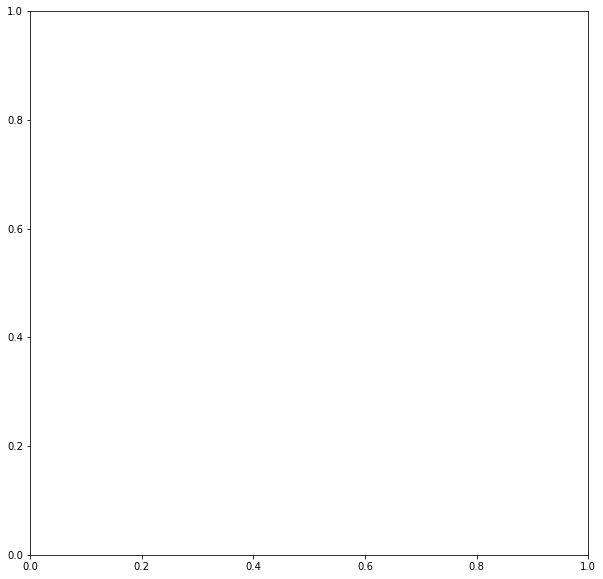

In [152]:
like = AL.get_likelihood()

A_range = np.linspace(prior[0,0], prior[1,0], gridsize)
B_range = np.linspace(prior[0,1], prior[1,1], gridsize)

A, B = np.meshgrid(A_range, B_range)


fig,ax = plt.subplots(figsize=(10,10))
mesh = ax.contourf(A_range, B_range, like)
plt.colorbar(mesh, ax=ax)

ax.scatter(θ_sim[0], θ_sim[1], zorder=10, marker='+', s=100, color='k')

ax.set_xlabel('A')
ax.set_ylabel('B')

